# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
#Author: Mark Abrenio (2019)

# Imports here

import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('Agg')

import time
import os
import copy
import sys

from torchvision import datasets
from torch.utils.data import DataLoader

from torch.autograd import Variable

from PIL import Image

from torch.optim import Adam
import torch.optim as optim
from torchvision import models
import torch.nn as nn

import matplotlib.image as mpimg

import time

import json

import random

import numpy as np

main_class_to_idx = 0


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# TODO: Define your transforms for the training, validation, and testing sets

data_transforms = {
	'train': transforms.Compose([
		transforms.RandomResizedCrop(224),
		transforms.RandomHorizontalFlip(),
		transforms.ToTensor(),
		transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	]),
	'val': transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(224),
		transforms.ToTensor(),
		transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	]),
}

# TODO: Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(train_dir, data_transforms["train"])

print "All Images, for Training:  "
print image_datasets.classes

evaluate_dataset = datasets.ImageFolder(test_dir, data_transforms["val"])

print "Eval Images, For Test: "
print evaluate_dataset.classes

print "Image Classes to IDX: "
print evaluate_dataset.class_to_idx
main_class_to_idx = evaluate_dataset.class_to_idx

# TODO: Using the image datasets and the trainforms, define the dataloaders

dataloaders = {}

train_loader = DataLoader(image_datasets, batch_size=100 ,shuffle=True, num_workers=1)

eval_loader = DataLoader(evaluate_dataset, batch_size=1 ,shuffle=True, num_workers=1)

dataloaders["train"] = train_loader #***well break up train and eval into seperate functions

All Images, for Training:  
['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Eval Images, For Test: 
['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', 

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [3]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
dataset_sizes = {}
dataset_sizes["train"] = len(image_datasets)

def class_to_idx(prediction): #we need to use this to map the image class IDX to its name
    for key in main_class_to_idx:
        if main_class_to_idx[key] == prediction:
            prediction = int(key)
            return prediction  #either we return the right image class or unknown!
    return "unknown"

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [4]:
# TODO: Build and train your network

def listdir_fullpath(path):     #returns all_da_symbols!

	for_return = []

	for path, subdirs, files in os.walk(path):
		for name in files:
			if "DS_Store" not in name:
				if name.endswith(".jpg"):
					for_return.append(os.path.join(path, name))

	return for_return

def fine_tune_model(model):
	n_classes = 0
	for param in model.parameters():    #lets just set them to no grad
			param.requires_grad = False
	n_inputs = 4096
	n_classes = len(cat_to_name.keys())
	dataset_sizes["train"] = len(listdir_fullpath(train_dir)) #***total num of images, for loss func
	dataset_sizes["eval"] = len(listdir_fullpath(test_dir)) #***total num of images, for loss func
	# Add on classifier
	model.classifier[6] = nn.Sequential(
					  nn.Linear(n_inputs, 256),
					  nn.ReLU(),
					  nn.Dropout(0.4),
					  nn.Linear(256, n_classes),
					  nn.LogSoftmax(dim=1))
	return model

def train_model(model, criterion, optimizer, scheduler, architecture, gpu_use, num_epochs=101):
	since = time.time()

	best_acc = 0.0

	for epoch in range(num_epochs):
		print('Epoch {}/{}'.format(epoch, num_epochs - 1))
		print('-' * 10)

		# Each epoch has a training and validation phase
		for phase in ['train']:
			if phase == 'train':
				#scheduler.step()
				model.train()  # Set model to training mode
			else:
				model.eval()   # Set model to evaluate mode

			running_loss = 0.0
			running_corrects = 0

			# Iterate over data.
			for inputs, labels in dataloaders[phase]:
				#print "iter"
				#inputs = inputs.to(device)
				#labels = labels.to(device)

				if cuda_available and gpu_use:
					inputs = Variable(inputs.cuda())
					labels = Variable(labels.cuda())

				# zero the parameter gradients
				optimizer.zero_grad()

				# forward
				# track history if only in train
				with torch.set_grad_enabled(phase == 'train'):
					outputs = model(inputs)
					_, preds = torch.max(outputs, 1)
					loss = criterion(outputs, labels)

					# backward + optimize only if in training phase
					if phase == 'train':
						loss.backward()
						optimizer.step()

				# statistics
				running_loss += loss.item() * inputs.size(0)
				running_corrects += torch.sum(preds == labels.data)

			epoch_loss = running_loss / dataset_sizes[phase]
			epoch_acc = running_corrects.double() / dataset_sizes[phase]
		if epoch % 10 == 0: #**Lets save ever 10 epochs!
				print "Saving and Reloading Model"
				da_model_file = save_models(epoch, model)
				model_checkpoint_load(da_model_file, architecture, gpu_use)
		print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
		print "Total Images: " + str(dataset_sizes[phase])
		print "Total Correctly Predicted: " + str(int(running_corrects))
	return da_model_file

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [5]:
# TODO: Do validation on the test set

def plot_categories(data):
	try:
		objects = list(data.keys())
		performance = list(data.values())
		y_pos = np.arange(len(objects))

		plt.bar(y_pos, performance, align='center', alpha=0.5)
		plt.xticks(y_pos, objects)
		plt.ylabel('PROBABILITY')
		plt.title('TOP 5 PROBABILITIES')
		plt.tick_params(axis='x', which='major', labelsize=8)
		plt.figure(figsize=(45,45)) #change its size
		plt.tight_layout()
		plt_result = plt.show()
		print "plotted"

	except Exception as e:
		print e
		print "Cannot Plot Categories!"

def my_top_5(outputs):
	data_for_plot = {}
	sm = torch.nn.Softmax(dim = 1)
	pop = sm(outputs)
	da_valuez, predictedTop5_test = pop.topk(5)
	da_valuez = da_valuez.tolist()
	da_valuez = da_valuez[0]
	predictedTop5_test = predictedTop5_test.tolist()
	predictedTop5_test = predictedTop5_test[0]
	throttle = 0
	for x in predictedTop5_test:
		real_class = class_to_idx(x)
		predictedTop5_test[throttle] = real_class
		throttle += 1
	throttle = 0
	while throttle < 5:
		da_top = predictedTop5_test[throttle]
		da_probability = da_valuez[throttle]
		da_probability = da_probability * 100
		real_label = str(da_top).decode("utf-8")
		pred_flower_name = cat_to_name[real_label]
		print pred_flower_name + " Probability: " + str(da_probability)
		throttle += 1
		data_for_plot[pred_flower_name] = da_probability #lets build the dictionary for the matplotlib
	return data_for_plot #*return the dictionary for matplotlib

def manual_scan_test(model, test_data_loader):
	model.eval()	#we do not need grads
	correct_accum = 0
	total_items = len(test_data_loader)

	for inputs, labels in test_data_loader:
	#if cuda_available:
		#                inputs = Variable(inputs.cuda())	#**lets put them onto the GPU
		#                labels = Variable(labels.cuda())
		try:
			outputs = model(inputs)
			_, prediction = torch.max(outputs.data, 1)
			correct_accum += torch.sum(prediction == labels.data)
			prediction = prediction.cpu().numpy()
			prediction = int(prediction)
			prediction = class_to_idx(prediction)
			prediction = str(prediction).decode("utf-8")
			real_label = labels.cpu().numpy()
			real_label = int(real_label)
			real_label = class_to_idx(real_label)
			real_label = str(real_label).decode("utf-8")
			pred_flower_name = cat_to_name[prediction]
			real_flower_name = cat_to_name[real_label]
			print "-----------"
			print "Flower is: " + real_flower_name
			print "Predicted Flower is: " + pred_flower_name
			print "label: " + real_label
			print "-----------"
		except Exception as e:
			print e
			print "Couldnt Predict This one."

	print "Total Items: " + str(total_items)
	print "Correctly Predicted: " + str(int(correct_accum))
	percentage = float(correct_accum) / float(total_items)
	percentage = percentage * 100
	print "Percentage Accuracy of Trained Network: " + str(float(percentage))
	return float(percentage), int(total_items), int(correct_accum)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [6]:
# TODO: Save the checkpoint 

#*fixed this per review to only use state_dict() to save model state. 

def save_models(epoch, model): #*only save state_dict, less file size
	print "Saving Model State To File"
	try:
		file_ext = str(random.randint(1, 99999))
		file_name = "LIVE_CNN_model_Statc_Dict.model." + file_ext
		checkpoint = {'input_size': (3, 224, 224),
					  'output_size': 102,
					  'batch_size': 100,
					  'learning_rate': learning_rate,
					  'model_name': "AIPND2",
					  'state_dict': model.state_dict(),
					  'optimizer': optimizer.state_dict(),
					  'epoch': epoch,
					  'classifier': model.classifier}
		torch.save(checkpoint, file_name)
		return file_name #***RETURN FILE NAME OF SAVED MODEL!
	except Exception as e:
		print e
		print "Could not save model to disk!"
		return 0

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [7]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

#***added model_checkpoint_load() to reload model periodically from state_dict() save.

def model_checkpoint_load(da_model_file, architecture, gpu_use):
	print "Loading Model State From File"
	try:
		checkpoint = torch.load(da_model_file)
		if "alex" in architecture:
			#model = getattr(torchvision.models, models.alexnet(pretrained=True))
			model = models.alexnet(pretrained=True)
		if "vgg" in architecture:
			#model = getattr(torchvision.models, models.vgg16(pretrained=True))
			model = models.vgg16(pretrained=True)
		for parameter in model.parameters(): #***freeze current params we place classifier below
			parameter.requires_grad = False

		model.classifier = checkpoint['classifier']
		model.load_state_dict(checkpoint['state_dict'])
		model.optimizer = checkpoint['optimizer']
		model.eval()
		if gpu_use:
			print "pushing model to GPU"
			model.cuda()
		return model
	except Exception as e:
		print e
		print "Could Not Load Model Check Point I sorry"
		return 0


def reload_model(epoch, model):
	try:
		model_fn = save_models(epoch, model)
		model = torch.load(model_fn)
		return model
	except Exception as e:
		print e
		return 0

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [8]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [9]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

def imshow_raw(image): #***well just show our test image raw. With our framework we can give the network a raw image
    img=mpimg.imread(image)
    imgplot = plt.imshow(img)
    plt.show()

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [10]:
#def predict(image_path, model, topk=5):
#    ''' Predict the class (or classes) of an image using a trained deep learning model.
#    '''
#    
#    # TODO: Implement the code to predict the class from an image file
    
def predict(model, da_transform, image):
    model.eval()
    import PIL
    print image
    image = PIL.Image.open(image)
    img = da_transform(image)
    img = img.unsqueeze(0)
    if gpu_use:
        img = Variable(img.cuda())
    outputs = model(img)
    _, prediction = torch.max(outputs.data, 1)
    prediction = class_to_idx(int(prediction))
    print "Image Class Number Predicted:" + str(prediction)
    pred_flower_name = cat_to_name[str(prediction)]
    print "Predicted Flower Type: " + pred_flower_name
    try:
        data = my_top_5(outputs)
        plot_categories(data)
        print "Plot Success"
    except Exception as e:
        print e
        print "ERROR: Could Not Plot Probabilities"

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [11]:
# TODO: Display an image along with the top 5 classes
#may 26

cuda_available = torch.cuda.is_available()
if cuda_available:
	print "SUCCESS: We have CUDA"
else:
	print "ERROR: NO GPU AVAILABLE"

from torch.optim import Adam
import torch.optim as optim

#***LOAD PRETRAINED

arg_count = len(sys.argv)
learning_rate = 0.001 #**this is the default learning rate!
learning_rate_set = False
manual_model_set_from_file = False
train_decision = False
evaluate_decision = False
gpu_use_decision = False
epoch_count_set = False
arc_choice = False

train_by_default = True

number_epochs = 0
man_model = ""
if arg_count > 1:
	throttle = 0
	for x in sys.argv:
		if x == "-l":
			learning_rate = sys.argv[throttle + 1]
			learning_rate_set = True
		if x == "-m":
			man_model = sys.argv[throttle + 1]
			manual_model_set_from_file = True
		if x == "-t":
			train_status = sys.argv[throttle + 1]
			if train_status == "y" or train_status == "yes":
				train_decision = True
				train_by_default = False
		if x == "-e":							#**CL arg to do evalutaion test of model. "-e yes"
			evaluate_status = sys.argv[throttle + 1]
			if evaluate_status == "y" or evaluate_status == "yes":
				evaluate_decision = True
		if x == "-gpu":
			gpu_status = sys.argv[throttle + 1]
			if gpu_status == "y" or gpu_status == "yes":
				gpu_use_decision = True
		if x == "-ec":
			number_epochs = sys.argv[throttle + 1]
			number_epochs = int(number_epochs)
			epoch_count_set = True
		if x == "-ac":
			chosen_arc = sys.argv[throttle + 1]
			arc_choice = True
			manual_model_set = True
		throttle += 1

manual_model_load = False
arch_in_use = 0

if manual_model_set_from_file == False: #**They want to
	if arc_choice:
		if chosen_arc == "vgg16":
			model = models.vgg16(pretrained=True)  #lets go ahead and use the VGG16 pretrained
			manual_model_load = False
			arch_in_use = "vgg16"
		elif chosen_arc == "alexnet":
			model = models.alexnet(pretrained=True)
			arch_in_use = "alexnet"
		else:
			print "You Did Specify An Available Model Type. Defaulting to VGG16"
			model = models.vgg16(pretrained=True)  # lets go ahead and use the VGG16 pretrained
			manual_model_load = False
			arch_in_use = "vgg16"
	else:
		print "ERROR: You Did not choose model type defaulting to AlexNet"
		model = models.alexnet(pretrained=True)  # lets go ahead and use the VGG16 pretrained
		manual_model_load = False
		arch_in_use = "alexnet"

if manual_model_set_from_file:
	model = torch.load(man_model, map_location='cpu')

print model

if manual_model_set_from_file == False:
	model = fine_tune_model(model)

print "Updated Model: "
print model

#optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.9)

scheduler = 0

evaluate_existing_model = True

trained_model_file_name = ""

num_epochs = 101 #***default num of epochs. Simply for testing.

if epoch_count_set:
	num_epochs = number_epochs
	print "NUMBER OF EPOCHS: " + str(num_epochs)
else:
	print "Using Default Epoch Count: 101" #**Setting EPOCH count lower for testing purposes
                                            #**Needs more EPOCHS for higher accuracy
        
if train_decision or train_by_default: #**will use GPU by default for training unless they specify no
	if cuda_available and gpu_use_decision:
			model.cuda() #**its too slow so we need to push it onto the GPU!!
			print "Model ON GPU"
			gpu_use = True
			trained_model_file_name = train_model(model, criterion, optimizer, scheduler, arch_in_use, gpu_use, num_epochs)
	else:
		print "NOT USING GPU. Going to be Slow."
		gpu_use = False
		trained_model_file_name = train_model(model, criterion, optimizer, scheduler, arch_in_use, gpu_use, num_epochs)
else:
	print "Decided not to train"


ERROR: NO GPU AVAILABLE
ERROR: You Did not choose model type defaulting to AlexNet
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_fea

Saving and Reloading Model
Saving Model State To File
Loading Model State From File
train Loss: 1.3193 Acc: 0.6654
Total Images: 819
Total Correctly Predicted: 545
Epoch 51/100
----------
train Loss: 1.3267 Acc: 0.6813
Total Images: 819
Total Correctly Predicted: 558
Epoch 52/100
----------
train Loss: 1.3292 Acc: 0.6581
Total Images: 819
Total Correctly Predicted: 539
Epoch 53/100
----------
train Loss: 1.2155 Acc: 0.7021
Total Images: 819
Total Correctly Predicted: 575
Epoch 54/100
----------
train Loss: 1.2284 Acc: 0.7057
Total Images: 819
Total Correctly Predicted: 578
Epoch 55/100
----------
train Loss: 1.2929 Acc: 0.6740
Total Images: 819
Total Correctly Predicted: 552
Epoch 56/100
----------
train Loss: 1.1881 Acc: 0.7033
Total Images: 819
Total Correctly Predicted: 576
Epoch 57/100
----------
train Loss: 1.1874 Acc: 0.7021
Total Images: 819
Total Correctly Predicted: 575
Epoch 58/100
----------
train Loss: 1.2502 Acc: 0.6899
Total Images: 819
Total Correctly Predicted: 565
Epoc

Testing Prediction Function
TEST FLOWER: RED GINGER PLANT


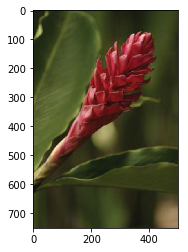

test_image.jpg
Image Class Number Predicted:24
Predicted Flower Type: red ginger
red ginger Probability: 64.3043637276
blackberry lily Probability: 6.0128044337
anthurium Probability: 4.36231680214
tiger lily Probability: 3.74710746109
bee balm Probability: 2.40587890148


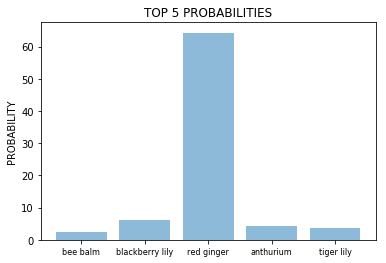

<Figure size 3240x3240 with 0 Axes>

plotted
Plot Success


In [12]:
print "Testing Prediction Function"
print "TEST FLOWER: RED GINGER PLANT"
imshow_raw("test_image.jpg")
predict(model, data_transforms['val'], "test_image.jpg")

In [13]:
evaluate_decision = True #***for display / review we will evaluate trained model by default

percentage_accuracy = 0

if evaluate_decision:
	percentage_accuracy = manual_scan_test(model, eval_loader)

-----------
Flower is: poinsettia
Predicted Flower is: poinsettia
label: 44
-----------
-----------
Flower is: wallflower
Predicted Flower is: wallflower
label: 46
-----------
-----------
Flower is: passion flower
Predicted Flower is: passion flower
label: 77
-----------
-----------
Flower is: buttercup
Predicted Flower is: buttercup
label: 48
-----------
-----------
Flower is: foxglove
Predicted Flower is: foxglove
label: 94
-----------
-----------
Flower is: poinsettia
Predicted Flower is: poinsettia
label: 44
-----------
-----------
Flower is: desert-rose
Predicted Flower is: desert-rose
label: 85
-----------
-----------
Flower is: azalea
Predicted Flower is: azalea
label: 72
-----------
-----------
Flower is: lenten rose
Predicted Flower is: lenten rose
label: 40
-----------
-----------
Flower is: silverbush
Predicted Flower is: silverbush
label: 64
-----------
-----------
Flower is: stemless gentian
Predicted Flower is: stemless gentian
label: 28
-----------
-----------
Flower is:

-----------
Flower is: desert-rose
Predicted Flower is: desert-rose
label: 85
-----------
-----------
Flower is: sunflower
Predicted Flower is: sunflower
label: 54
-----------
-----------
Flower is: wild pansy
Predicted Flower is: wild pansy
label: 52
-----------
-----------
Flower is: canna lily
Predicted Flower is: water lily
label: 90
-----------
-----------
Flower is: canna lily
Predicted Flower is: canna lily
label: 90
-----------
-----------
Flower is: bee balm
Predicted Flower is: bee balm
label: 92
-----------
-----------
Flower is: peruvian lily
Predicted Flower is: peruvian lily
label: 18
-----------
-----------
Flower is: grape hyacinth
Predicted Flower is: grape hyacinth
label: 25
-----------
-----------
Flower is: yellow iris
Predicted Flower is: yellow iris
label: 15
-----------
-----------
Flower is: buttercup
Predicted Flower is: buttercup
label: 48
-----------
-----------
Flower is: english marigold
Predicted Flower is: english marigold
label: 5
-----------
-----------

-----------
Flower is: hippeastrum
Predicted Flower is: hippeastrum
label: 91
-----------
-----------
Flower is: mexican petunia
Predicted Flower is: mexican petunia
label: 98
-----------
-----------
Flower is: cape flower
Predicted Flower is: cape flower
label: 37
-----------
-----------
Flower is: love in the mist
Predicted Flower is: love in the mist
label: 33
-----------
-----------
Flower is: geranium
Predicted Flower is: geranium
label: 58
-----------
-----------
Flower is: fritillary
Predicted Flower is: fritillary
label: 23
-----------
-----------
Flower is: garden phlox
Predicted Flower is: garden phlox
label: 32
-----------
-----------
Flower is: gaura
Predicted Flower is: gaura
label: 57
-----------
-----------
Flower is: petunia
Predicted Flower is: petunia
label: 51
-----------
-----------
Flower is: great masterwort
Predicted Flower is: great masterwort
label: 38
-----------
-----------
Flower is: garden phlox
Predicted Flower is: garden phlox
label: 32
-----------
------

-----------
Flower is: water lily
Predicted Flower is: water lily
label: 73
-----------
-----------
Flower is: wallflower
Predicted Flower is: wallflower
label: 46
-----------
-----------
Flower is: passion flower
Predicted Flower is: passion flower
label: 77
-----------
-----------
Flower is: petunia
Predicted Flower is: petunia
label: 51
-----------
-----------
Flower is: clematis
Predicted Flower is: clematis
label: 82
-----------
-----------
Flower is: wallflower
Predicted Flower is: wallflower
label: 46
-----------
-----------
Flower is: great masterwort
Predicted Flower is: great masterwort
label: 38
-----------
-----------
Flower is: stemless gentian
Predicted Flower is: stemless gentian
label: 28
-----------
-----------
Flower is: poinsettia
Predicted Flower is: poinsettia
label: 44
-----------
-----------
Flower is: pelargonium
Predicted Flower is: pelargonium
label: 55
-----------
-----------
Flower is: petunia
Predicted Flower is: petunia
label: 51
-----------
-----------
Fl

-----------
Flower is: giant white arum lily
Predicted Flower is: giant white arum lily
label: 20
-----------
-----------
Flower is: purple coneflower
Predicted Flower is: purple coneflower
label: 17
-----------
-----------
Flower is: cape flower
Predicted Flower is: cape flower
label: 37
-----------
-----------
Flower is: azalea
Predicted Flower is: azalea
label: 72
-----------
-----------
Flower is: sword lily
Predicted Flower is: sword lily
label: 43
-----------
-----------
Flower is: artichoke
Predicted Flower is: artichoke
label: 29
-----------
-----------
Flower is: hippeastrum
Predicted Flower is: hippeastrum
label: 91
-----------
-----------
Flower is: bougainvillea
Predicted Flower is: bougainvillea
label: 95
-----------
-----------
Flower is: watercress
Predicted Flower is: watercress
label: 89
-----------
-----------
Flower is: gazania
Predicted Flower is: gazania
label: 71
-----------
-----------
Flower is: orange dahlia
Predicted Flower is: orange dahlia
label: 59
--------

-----------
Flower is: blanket flower
Predicted Flower is: blanket flower
label: 100
-----------
-----------
Flower is: pincushion flower
Predicted Flower is: pincushion flower
label: 22
-----------
-----------
Flower is: japanese anemone
Predicted Flower is: japanese anemone
label: 62
-----------
-----------
Flower is: bird of paradise
Predicted Flower is: bird of paradise
label: 8
-----------
-----------
Flower is: moon orchid
Predicted Flower is: moon orchid
label: 7
-----------
-----------
Flower is: bird of paradise
Predicted Flower is: bird of paradise
label: 8
-----------
-----------
Flower is: giant white arum lily
Predicted Flower is: giant white arum lily
label: 20
-----------
-----------
Flower is: foxglove
Predicted Flower is: foxglove
label: 94
-----------
-----------
Flower is: tiger lily
Predicted Flower is: tiger lily
label: 6
-----------
-----------
Flower is: garden phlox
Predicted Flower is: garden phlox
label: 32
-----------
-----------
Flower is: water lily
Predict

-----------
Flower is: tree poppy
Predicted Flower is: tree poppy
label: 70
-----------
-----------
Flower is: moon orchid
Predicted Flower is: moon orchid
label: 7
-----------
-----------
Flower is: garden phlox
Predicted Flower is: garden phlox
label: 32
-----------
-----------
Flower is: love in the mist
Predicted Flower is: love in the mist
label: 33
-----------
-----------
Flower is: tiger lily
Predicted Flower is: tiger lily
label: 6
-----------
-----------
Flower is: lenten rose
Predicted Flower is: lenten rose
label: 40
-----------
-----------
Flower is: bougainvillea
Predicted Flower is: bougainvillea
label: 95
-----------
-----------
Flower is: wallflower
Predicted Flower is: wallflower
label: 46
-----------
-----------
Flower is: cyclamen
Predicted Flower is: cyclamen
label: 88
-----------
-----------
Flower is: thorn apple
Predicted Flower is: thorn apple
label: 75
-----------
-----------
Flower is: sweet pea
Predicted Flower is: sword lily
label: 4
-----------
-----------


-----------
Flower is: buttercup
Predicted Flower is: buttercup
label: 48
-----------
-----------
Flower is: purple coneflower
Predicted Flower is: purple coneflower
label: 17
-----------
-----------
Flower is: primula
Predicted Flower is: primula
label: 53
-----------
-----------
Flower is: moon orchid
Predicted Flower is: moon orchid
label: 7
-----------
-----------
Flower is: grape hyacinth
Predicted Flower is: grape hyacinth
label: 25
-----------
-----------
Flower is: bearded iris
Predicted Flower is: bearded iris
label: 68
-----------
-----------
Flower is: clematis
Predicted Flower is: clematis
label: 82
-----------
-----------
Flower is: geranium
Predicted Flower is: geranium
label: 58
-----------
-----------
Flower is: passion flower
Predicted Flower is: passion flower
label: 77
-----------
-----------
Flower is: passion flower
Predicted Flower is: passion flower
label: 77
-----------
-----------
Flower is: clematis
Predicted Flower is: clematis
label: 82
-----------
---------

-----------
Flower is: ball moss
Predicted Flower is: ball moss
label: 93
-----------
-----------
Flower is: canna lily
Predicted Flower is: canna lily
label: 90
-----------
-----------
Flower is: bougainvillea
Predicted Flower is: bougainvillea
label: 95
-----------
-----------
Flower is: bird of paradise
Predicted Flower is: bird of paradise
label: 8
-----------
-----------
Flower is: colt's foot
Predicted Flower is: colt's foot
label: 12
-----------
-----------
Flower is: passion flower
Predicted Flower is: passion flower
label: 77
-----------
-----------
Flower is: daffodil
Predicted Flower is: daffodil
label: 42
-----------
-----------
Flower is: geranium
Predicted Flower is: geranium
label: 58
-----------
-----------
Flower is: spring crocus
Predicted Flower is: spring crocus
label: 67
-----------
-----------
Flower is: rose
Predicted Flower is: rose
label: 74
-----------
-----------
Flower is: canna lily
Predicted Flower is: canna lily
label: 90
-----------
-----------
Flower is

In [14]:
print "TOTAL NUMBER OF IMAGES CHECKED AGAINST MODEL: " + str(percentage_accuracy[1])
print "IMAGES CORRECTLY PREDICTED: " + str(percentage_accuracy[2])
print "PERCENTAGE ACCURACY OF TRAINED NETWORK: " + str(percentage_accuracy[0])
print "FINAL SAVED MODEL FILE NAME: " + trained_model_file_name

TOTAL NUMBER OF IMAGES CHECKED AGAINST MODEL: 819
IMAGES CORRECTLY PREDICTED: 811
PERCENTAGE ACCURACY OF TRAINED NETWORK: 99.0231990232
FINAL SAVED MODEL FILE NAME: LIVE_CNN_model_Statc_Dict.model.12563
